# Exploratory data analysis
In this project we are working with data on hourly energy demand consumption and generation in combination with weather data. The chosen dataset contains 4 years of electrical consumption, generation, pricing, and weather data for Spain. More details about the dataset can be found [here](https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather?fbclid=IwAR0xdOUu0k8vYs8G_BiKxkGfXy2LU-tVtZGvMouhmi_Im93yAsEcATIPoQ8).

TODO: Add research question

In [2]:
import nltk
# nltk.download('punkt')
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import re
from tqdm import tqdm
import seaborn as sns

plt.style.use('ggplot')
import itertools
palette = itertools.cycle(sns.color_palette())

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load data

In [3]:
df1 = pd.read_csv('data/energy_dataset.csv', parse_dates = True)
original_cols = df1.columns
original_cols

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')

We start by looking at the data info to see if there are any Null values to be aware of

In [4]:
df1.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

We see that we can drop the columns `generation hydro pumped storage aggregated` and `forecast wind offshore eday ahead` right from the start, as they have no non-null values. Also, we can change the dtype of `time` to be `datetime64` instead of object. Then we will also set the `time` as the dataframe index for convenience.

In [5]:
df1 = df1.drop(['generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead'], axis=1)
df1['time'] = pd.to_datetime(df1['time'], utc=True)
df1 = df1.set_index('time')

We then drop all features, if any exist, where all values are 0 as they won't really be relevant.

In [6]:
# drop columns where all values are 0
df1.drop(df1.columns[df1.sum(axis = 0) == 0], axis = 1, inplace = True)
non_zero_cols = df1.columns
non_zero_cols

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')

The columns that were removed are:

In [7]:
set(original_cols).difference(non_zero_cols)

{'forecast wind offshore eday ahead',
 'generation fossil coal-derived gas',
 'generation fossil oil shale',
 'generation fossil peat',
 'generation geothermal',
 'generation hydro pumped storage aggregated',
 'generation marine',
 'generation wind offshore',
 'time'}

**N.B.** `time` is not remove, it has just been set as the dataframe index and thereby is not part of the `df1.columns` anymore.

### Prepare energy data
As can be seen above the dataset contains a quite high degree of detail on the sources of energy generation.
<br>
To reduce the number of features a bit while maintaining the main groups of energy sources we choose to combine all `fossil` generated fuels into a single feature called `generation fossil` and to combine all `hydro` energy sources into a feature called `generation hydro`.

In [8]:
# sum all columns with fossil generation
fossil_cols = df1.columns[[re.match("generation fossil", s) is not None for s in df1.columns]]
df1['generation fossil'] = df1[fossil_cols].sum(axis = 1)
df1 = df1.drop(fossil_cols, axis = 1) # delete fossil cols

# sum all hydro columns
hydro_cols = df1.columns[[re.match("generation hydro", s) is not None for s in df1.columns]]
df1['generation hydro'] = df1[hydro_cols].sum(axis = 1)
df1 = df1.drop(hydro_cols, axis = 1) # delete hydro cols
df1.columns

Index(['generation biomass', 'generation nuclear', 'generation other',
       'generation other renewable', 'generation solar', 'generation waste',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind onshore day ahead', 'total load forecast',
       'total load actual', 'price day ahead', 'price actual',
       'generation fossil', 'generation hydro'],
      dtype='object')

We then also would like to have the consumption/generation data from the Transmission Service Operator (TSO) split into observed and predicted data.

In [9]:
# split in TSO forecast and observed 
forecast_cols = list(df1.columns[[bool(re.findall("forecast", s)) for s in df1.columns]])
forecast_cols += ['price day ahead']
TSO_forecasts = df1[forecast_cols]
TSO_forecasts.to_csv("preprocessed_data/TSO_forecasts.csv")

df1 = df1.drop(forecast_cols, axis = 1) # delete forecast cols
df1["generation total"] = df1[df1.columns[[bool(re.findall("generation", s)) for s in df1.columns]]].sum(axis = 1) # add column with total generation
df1 = df1[df1.columns.sort_values()] # sort order of columns

Now we can try a get an overview of how the remaining features look

In [11]:
df1.describe()

,generation biomass,generation fossil,generation hydro,generation nuclear,generation other,generation other renewable,generation solar,generation total,generation waste,generation wind onshore,price actual,total load actual
count,35045.000000,35064.000000,35064.000000,35047.000000,35046.000000,35046.000000,35046.000000,35064.000000,35045.000000,35046.000000,35064.000000,35028.000000
mean,383.513540,10619.719313,4050.686402,6263.907039,60.228585,85.639702,1432.665925,28623.286162,269.452133,5464.479769,57.884023,28696.939905
std,85.353943,3946.767547,2115.462454,839.667958,20.238381,14.077554,1680.119887,4233.491084,50.195536,3213.691587,14.204083,4574.987950
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.330000,18041.000000
25%,333.000000,7398.750000,2391.000000,5760.000000,53.000000,73.000000,71.000000,25441.000000,240.000000,2933.000000,49.347500,24807.750000
50%,367.000000,10415.000000,3587.000000,6566.000000,57.000000,88.000000,616.000000,28454.000000,279.000000,4849.000000,58.020000,28901.000000
75%,433.000000,13294.250000,5313.000000,7025.000000,80.000000,97.000000,2578.000000,31568.000000,310.000000,7398.000000,68.010000,32192.000000
max,592.000000,28085.000000,11613.000000,7117.000000,106.000000,119.000000,5792.000000,42310.000000,357.000000,17436.000000,116.800000,41015.000000


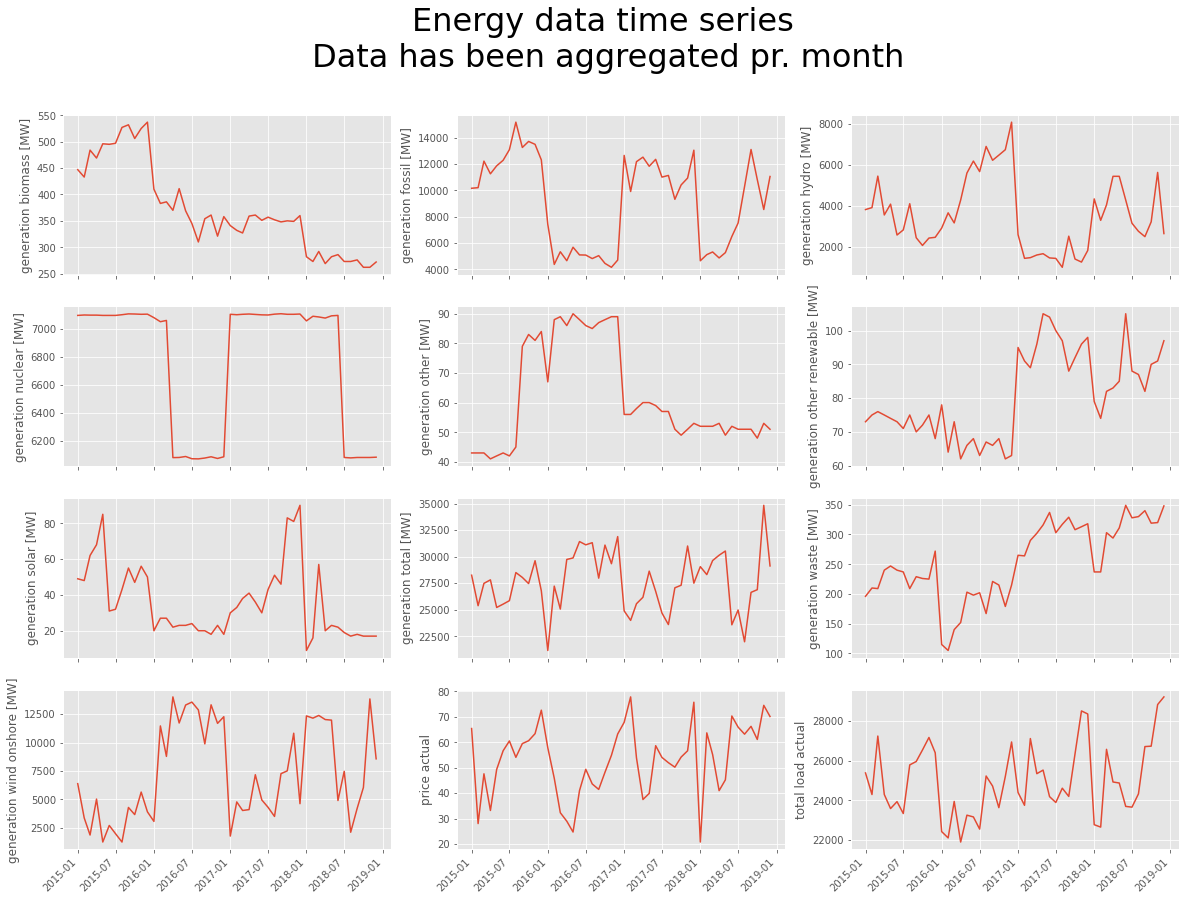

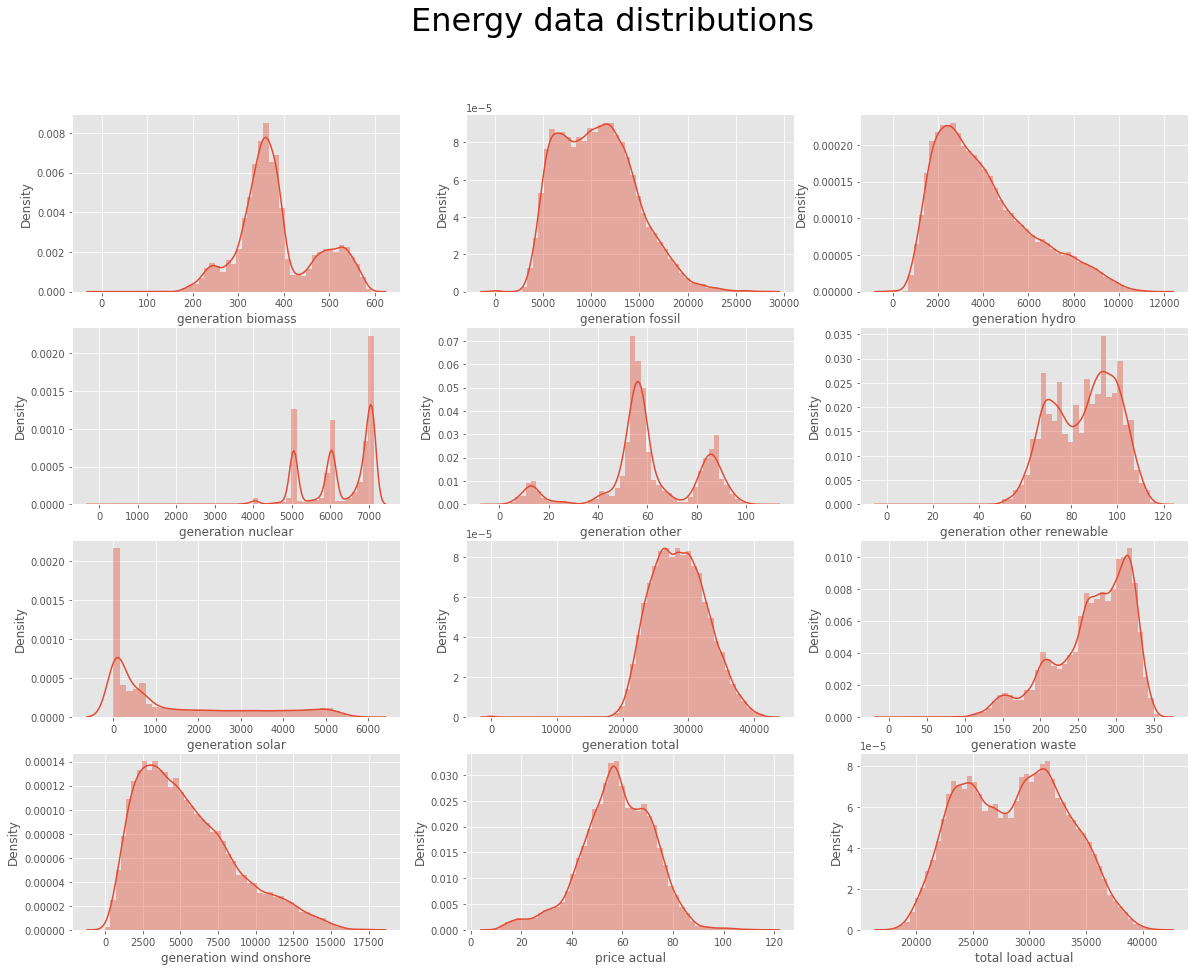

In [ ]:
fig, ax = plt.subplots(4,3, figsize = (20,15))
fig2, ax2 = plt.subplots(4,3, figsize = (20,15))

# plot titles
fig.suptitle("Energy data time series\n Data has been aggregated pr. month", size = 32)
fig2.suptitle("Energy data distributions", size = 32)

# aggregate time series
ts_agg = df1.asfreq("M") 

i = 0
for col_name in df1.columns:
    # time series plot
    if re.findall("generation", col_name):
        ax[i//3, i%3].set_ylabel(col_name + " [MW]")  
    else:
        ax[i//3, i%3].set_ylabel(col_name)  
    plot = ax[i//3, i%3].plot(ts_agg.index, ts_agg[col_name])
    fig.autofmt_xdate(rotation=45)

    # dist plot
    sns.distplot(df1[col_name], ax = ax2[i//3, i%3])

    # update axis index
    i += 1

In [12]:
df1.asfreq("D")

,generation biomass,generation fossil,generation hydro,generation nuclear,generation other,generation other renewable,generation solar,generation total,generation waste,generation wind onshore,price actual,total load actual
time,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,10156.0,3813.0,7096.0,43.0,73.0,49.0,28251.0,196.0,6378.0,65.41,25385.0
2015-01-01 23:00:00+00:00,368.0,4673.0,6429.0,7106.0,45.0,62.0,54.0,32138.0,169.0,13232.0,64.02,27070.0
2015-01-02 23:00:00+00:00,478.0,5845.0,5644.0,7096.0,78.0,76.0,62.0,28744.0,201.0,9264.0,66.82,25564.0
2015-01-03 23:00:00+00:00,391.0,6863.0,4538.0,7086.0,81.0,58.0,692.0,28411.0,162.0,8540.0,55.22,25254.0
2015-01-04 23:00:00+00:00,373.0,10263.0,3918.0,4036.0,41.0,72.0,691.0,26903.0,158.0,7351.0,70.77,25069.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-26 23:00:00+00:00,309.0,9970.0,4522.0,6065.0,62.0,90.0,20.0,22945.0,302.0,1605.0,72.61,24679.0
2018-12-27 23:00:00+00:00,317.0,10661.0,3599.0,6074.0,61.0,94.0,15.0,22667.0,309.0,1537.0,70.93,25147.0
2018-12-28 23:00:00+00:00,313.0,7714.0,2412.0,6075.0,60.0,101.0,15.0,23946.0,313.0,6943.0,65.49,25709.0


In [17]:
df1

,generation biomass,generation fossil,generation hydro,generation nuclear,generation other,generation other renewable,generation solar,generation total,generation waste,generation wind onshore,price actual,total load actual
time,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,10156.0,3813.0,7096.0,43.0,73.0,49.0,28251.0,196.0,6378.0,65.41,25385.0
2015-01-01 00:00:00+00:00,449.0,10437.0,3587.0,7096.0,43.0,71.0,50.0,27818.0,195.0,5890.0,64.92,24382.0
2015-01-01 01:00:00+00:00,448.0,9918.0,3508.0,7099.0,43.0,73.0,50.0,26796.0,196.0,5461.0,64.48,22734.0
2015-01-01 02:00:00+00:00,438.0,8859.0,3231.0,7098.0,43.0,75.0,50.0,25223.0,191.0,5238.0,59.32,21286.0
2015-01-01 03:00:00+00:00,428.0,8313.0,3499.0,7097.0,43.0,74.0,42.0,24620.0,189.0,4935.0,56.04,20264.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,297.0,10440.0,5972.0,6073.0,63.0,95.0,85.0,26415.0,277.0,3113.0,77.02,30653.0
2018-12-31 19:00:00+00:00,296.0,9981.0,5104.0,6074.0,62.0,95.0,33.0,25213.0,280.0,3288.0,76.16,29735.0
2018-12-31 20:00:00+00:00,292.0,9615.0,4029.0,6076.0,61.0,94.0,31.0,23987.0,286.0,3503.0,74.30,28071.0


### Prepare weather data

In [25]:
df2 = pd.read_csv('data/weather_features.csv')
df2.columns

Index(['dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h',
       'clouds_all', 'weather_id', 'weather_main', 'weather_description',
       'weather_icon'],
      dtype='object')

Let's first have a look at how many rows contain NaN values

In [26]:
df2.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

So it seems like there are no Null values in the weather data.
<br>
We remove the `weather_icon` as it is of not relevance to us.
<br>
Again we make the time feature `dt_iso` into `datetime64` and set it as the dataframe index.
<br>
Also, we have several text feature which we start out by cleaning up a little.

In [27]:
# Converting to datetime64 and setting as df index
df2['dt_iso'] = pd.to_datetime(df2['dt_iso'], utc=True)
df2.set_index('dt_iso')

# Remove weather_icon
df2 = df2.drop('weather_icon', axis=1)

# Cleaning text features
def clean_text(text):
    text = text.strip().lower()
    return ' '.join([w for w in word_tokenize(text)])

text_cols = df2.select_dtypes(include=['object']).columns
for tc in tqdm(text_cols):
    df2[tc] = df2[tc].apply(clean_text)

100%|██████████| 3/3 [00:15<00:00,  5.23s/it]


The data is from the Spanish cities seen below:

In [28]:
df2['city_name'].unique()

array(['valencia', 'madrid', 'bilbao', 'barcelona', 'seville'],
      dtype=object)

The number of observations per city is:

In [29]:
df2['city_name'].value_counts()

madrid       36267
bilbao       35951
seville      35557
barcelona    35476
valencia     35145
Name: city_name, dtype: int64

We will handle each city separately:

In [30]:
# create dictionary with city as key and subset of data frame as value
df2_city_groups = df2.groupby('city_name')
df2_city_groups.groups.keys()

dict_keys(['barcelona', 'bilbao', 'madrid', 'seville', 'valencia'])

In [31]:
df2_city_groups.aggregate(['mean', 'std'])

temp              temp_min              temp_max            \
                 mean       std        mean       std        mean       std   
city_name                                                                     
barcelona  289.848248  6.712455  288.594704  6.447358  291.021987  7.277714   
bilbao     286.378489  6.795776  284.916661  6.820451  288.036687  6.971775   
madrid     288.061071  9.298482  286.824877  9.159233  289.155600  9.647888   
seville    293.105431  8.065712  291.184103  8.244529  295.962431  9.070491   
valencia   290.780780  7.231284  290.222277  7.087512  291.355025  7.519891   

              pressure                 humidity             ...   rain_1h  \
                  mean           std       mean        std  ...      mean   
city_name                                                   ...             
barcelona  1284.010486  13384.650972  73.994221  17.722541  ...  0.117079   
bilbao     1017.567439      9.797704  79.089455  16.709133  ...  0.123493   
madrid     1011.838448     19.981283  59.776932  25.223242  ...  0.055083   
seville    1018.504711      6.879094  64.140732  22.978531  ...  0.045392   
valencia   1015.973794     11.927677  65.145113  19.689276  ...  0.035924   

                      rain_3h             snow_3h           clouds_all  \
                std      mean       std      mean       std       mean   
city_name                                                                
barcelona  0.691662  0.000327  0.003977  0.000000  0.000000  23.229648   
bilbao     0.373237  0.001034  0.014738  0.023455  0.495266  43.960697   
madrid     0.224408  0.000129  0.002547  0.000029  0.005508  22.397028   
seville    0.225223  0.000180  0.003408  0.000000  0.000000  14.748770   
valencia   0.267955  0.000226  0.003531  0.000154  0.011898  20.820999   

                      weather_id              
                 std        mean         std  
city_name                                     
barcelona  27.712186  760.917465  111.319965  
bilbao     33.749299  723.943228  134.891801  
madrid     30.872272  762.260264  109.287351  
seville    26.740267  771.409849   90.507081  
valencia   25.658433  781.228283   79.759832  

[5 rows x 24 columns]

In [35]:
df2

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description
0,2014-12-31 23:00:00+00:00,valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear
1,2015-01-01 00:00:00+00:00,valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear
2,2015-01-01 01:00:00+00:00,valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear
3,2015-01-01 02:00:00+00:00,valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear
4,2015-01-01 03:00:00+00:00,valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 18:00:00+00:00,seville,287.760,287.150,288.150,1028,54,3,30,0.0,0.0,0.0,0,800,clear,sky is clear
178392,2018-12-31 19:00:00+00:00,seville,285.760,285.150,286.150,1029,62,3,30,0.0,0.0,0.0,0,800,clear,sky is clear
178393,2018-12-31 20:00:00+00:00,seville,285.150,285.150,285.150,1028,58,4,50,0.0,0.0,0.0,0,800,clear,sky is clear
178394,2018-12-31 21:00:00+00:00,seville,284.150,284.150,284.150,1029,57,4,60,0.0,0.0,0.0,0,800,clear,sky is clear


### Merge weather and energy data

In [39]:
df2_city_groups.get_group("valencia")

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description
0,2014-12-31 23:00:00+00:00,valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear
1,2015-01-01 00:00:00+00:00,valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear
2,2015-01-01 01:00:00+00:00,valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear
3,2015-01-01 02:00:00+00:00,valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear
4,2015-01-01 03:00:00+00:00,valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35140,2018-12-31 18:00:00+00:00,valencia,285.640,285.150,286.150,1028,62,2,140,0.0,0.0,0.0,0,800,clear,sky is clear
35141,2018-12-31 19:00:00+00:00,valencia,283.140,282.150,284.150,1029,71,1,242,0.0,0.0,0.0,0,800,clear,sky is clear
35142,2018-12-31 20:00:00+00:00,valencia,281.660,281.150,282.150,1029,81,3,300,0.0,0.0,0.0,0,800,clear,sky is clear
35143,2018-12-31 21:00:00+00:00,valencia,280.140,279.150,281.150,1029,81,2,310,0.0,0.0,0.0,0,800,clear,sky is clear


In [40]:
# not all data frames share all time stamps, thus we find the common time stamps
# common_times = set(df1.index)
# for val in df2_dict.values():
#     common_times = set(val.dt_iso).intersection(common_times)

# common_times = list(common_times)
# common_times.sort()

# combine df1 with a chosen city's weather data
city = "valencia"
df = df1.merge(df2_city_groups.get_group(city), how = "left", left_on="time", right_on = "dt_iso")

AttributeError: 'DataFrameGroupBy' object has no attribute 'get'

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fa727d48-3f61-4323-a991-52ec9b01cc46' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>